In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pickle
from pprint import pprint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, explained_variance_score
from skimage.metrics import normalized_root_mse

In [2]:
dataset = pd.read_csv('Edited_Korea_Original.csv')
dataset

,Measurement date,Station code,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01 00:00,101,0.004,0.059,0.002,1.2,73.0,57.0
1,2017-01-01 00:00,102,0.006,0.068,0.002,1.3,77.0,63.0
2,2017-01-01 00:00,103,0.005,0.039,0.002,1.4,70.0,68.0
3,2017-01-01 00:00,104,0.005,0.045,0.003,0.6,73.0,46.0
4,2017-01-01 00:00,105,0.005,0.044,0.004,1.0,81.0,44.0
...,...,...,...,...,...,...,...,...
656995,2019-12-31 23:00,121,0.003,0.042,0.013,0.5,29.0,16.0
656996,2019-12-31 23:00,122,0.003,0.047,0.007,0.4,24.0,15.0
656997,2019-12-31 23:00,123,0.003,0.039,0.003,0.5,19.0,13.0
656998,2019-12-31 23:00,124,0.003,0.035,0.004,0.5,20.0,13.0


In [3]:
df = dataset[dataset['Station code'] == 101].iloc[:,2:]
df

,SO2,NO2,O3,CO,PM10,PM2.5
0,0.004,0.059,0.002,1.2,73.0,57.0
25,0.004,0.058,0.002,1.2,71.0,59.0
50,0.004,0.056,0.002,1.2,70.0,59.0
75,0.004,0.056,0.002,1.2,70.0,58.0
100,0.003,0.051,0.002,1.2,69.0,61.0
...,...,...,...,...,...,...
656875,0.003,0.026,0.014,0.5,26.0,19.0
656900,0.003,0.024,0.014,0.4,27.0,19.0
656925,0.003,0.014,0.021,0.4,23.0,18.0
656950,0.003,0.022,0.014,0.5,20.0,19.0


In [4]:
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(df)
df1.shape

(26280, 6)

In [5]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step)]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step])
	return np.array(dataX), np.array(dataY)

In [6]:
time_step = 36
training_size = int(len(df1)*0.7)
test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size,:], df1[training_size - time_step:len(df1),:]
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [7]:
training_size, test_size

(18396, 7884)

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((18359, 36, 6), (18359, 6), (7883, 36, 6), (7883, 6))

In [9]:
learning_rate = 0.001
model = Sequential()
model.add(LSTM(128, input_shape = (X_test.shape[1:])))
#model.add(LSTM(128, return_sequences = True))
#model.add(LSTM(128))
#model.add(Activation('softmax'))
model.add(Dense(X_test.shape[2]))
model.compile(optimizer = keras.optimizers.Adam(learning_rate = learning_rate), loss = "mean_absolute_error", metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               69120     
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 69,894
Trainable params: 69,894
Non-trainable params: 0
_________________________________________________________________


In [10]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0, patience = 5, restore_best_weights=True)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor = "val_loss",
    filepath = path_checkpoint,
    verbose = 1,
    save_weights_only = True,
    save_best_only = True,
)

history = model.fit(
    X_train,
    y_train,
    validation_data = (X_test, y_test),
    epochs = 100,
    batch_size = 256,
    verbose = 1,
    #callbacks = [es_callback, modelckpt_callback]
    callbacks = [es_callback]
    )

Epoch 1/100
72/72 [==============================] - 27s 40ms/step - loss: 0.0746 - accuracy: 0.4773 - val_loss: 0.0476 - val_accuracy: 0.5909
Epoch 2/100
72/72 [==============================] - 2s 33ms/step - loss: 0.0489 - accuracy: 0.6420 - val_loss: 0.0395 - val_accuracy: 0.6420
Epoch 3/100
72/72 [==============================] - 2s 24ms/step - loss: 0.0419 - accuracy: 0.6918 - val_loss: 0.0347 - val_accuracy: 0.6939
Epoch 4/100
72/72 [==============================] - 2s 25ms/step - loss: 0.0370 - accuracy: 0.7301 - val_loss: 0.0326 - val_accuracy: 0.7330
Epoch 5/100
72/72 [==============================] - 3s 36ms/step - loss: 0.0341 - accuracy: 0.7521 - val_loss: 0.0301 - val_accuracy: 0.7344
Epoch 6/100
72/72 [==============================] - 2s 27ms/step - loss: 0.0325 - accuracy: 0.7616 - val_loss: 0.0287 - val_accuracy: 0.7567
Epoch 7/100
72/72 [==============================] - 3s 44ms/step - loss: 0.0316 - accuracy: 0.7686 - val_loss: 0.0281 - val_accuracy: 0.7521
Epoch

In [11]:
#model.save_weights('lstm_model')

In [12]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [13]:
features = df.columns.values
features

array(['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5'], dtype=object)

In [14]:
print('Train values')
for i, feature in enumerate(features):
    obj = [j[i] for j in scaler.inverse_transform(y_train)]
    pred = [j[i] for j in scaler.inverse_transform(train_predict)]
    print(f'RMSE for {feature} is {mean_squared_error(obj, pred, squared=False)}')
    print(f'CV for {feature} is {explained_variance_score(obj, pred)}')
    print(f'NRMSE {normalized_root_mse(np.array(obj), np.array(pred))}')
    print()

Train values
RMSE for SO2 is 0.0006788986416016846
CV for SO2 is 0.8393188779697707
NRMSE 0.14190098407365628

RMSE for NO2 is 0.006080857608337091
CV for NO2 is 0.8723961828860065
NRMSE 0.1646037493171458

RMSE for O3 is 0.007300030018466209
CV for O3 is 0.8555102072747088
NRMSE 0.23385139064501984

RMSE for CO is 0.10016433399944318
CV for CO is 0.8521782141034203
NRMSE 0.15786997227293567

RMSE for PM10 is 7.767490276017959
CV for PM10 is 0.901075713801506
NRMSE 0.17030181578305026

RMSE for PM2.5 is 5.299608772367572
CV for PM2.5 is 0.905379956407947
NRMSE 0.18526128347212664



In [15]:
print('Test values')
for i, feature in enumerate(features):
    obj = [j[i] for j in scaler.inverse_transform(y_test)]
    pred = [j[i] for j in scaler.inverse_transform(test_predict)]
    print(f'RMSE for {feature} is {mean_squared_error(obj, pred, squared=False)}')
    print(f'CV for {feature} is {explained_variance_score(obj, pred)}')
    print()


Test values
RMSE for SO2 is 0.000578557592132024
CV for SO2 is 0.6710848813106798

RMSE for NO2 is 0.005398206600203839
CV for NO2 is 0.8680048203672248

RMSE for O3 is 0.005929047370210074
CV for O3 is 0.8809606272068045

RMSE for CO is 0.08289671067844313
CV for CO is 0.8607571486506325

RMSE for PM10 is 9.01399161229066
CV for PM10 is 0.8617760179060342

RMSE for PM2.5 is 7.364263341048092
CV for PM2.5 is 0.8135601506948361



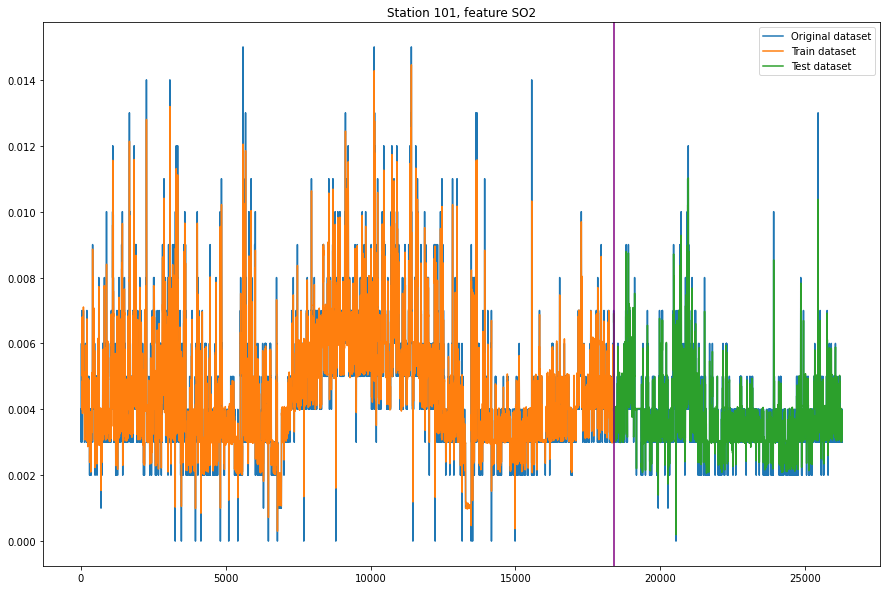

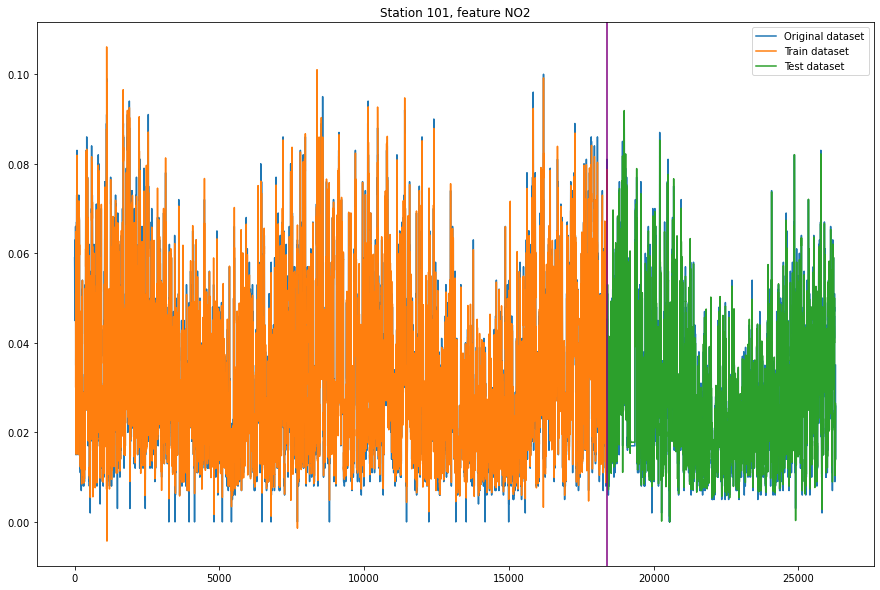

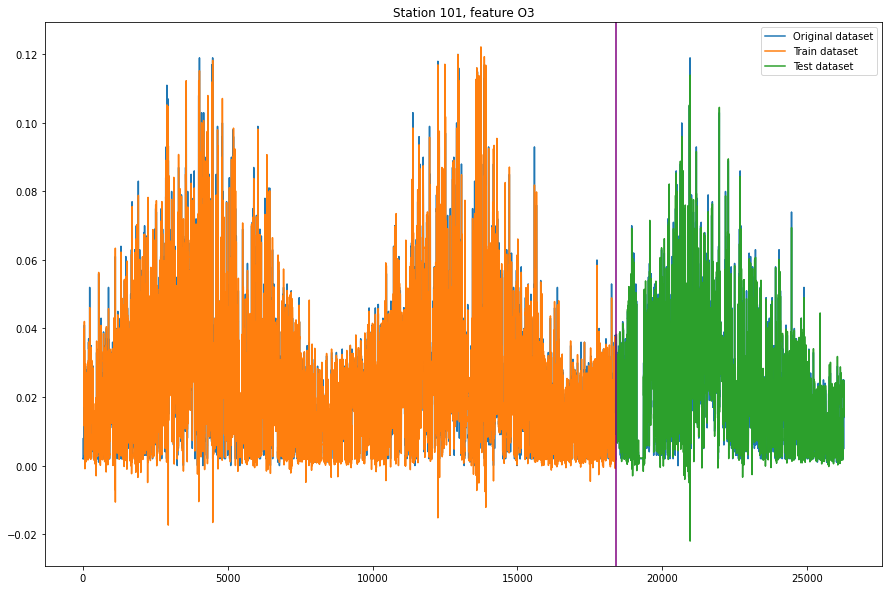

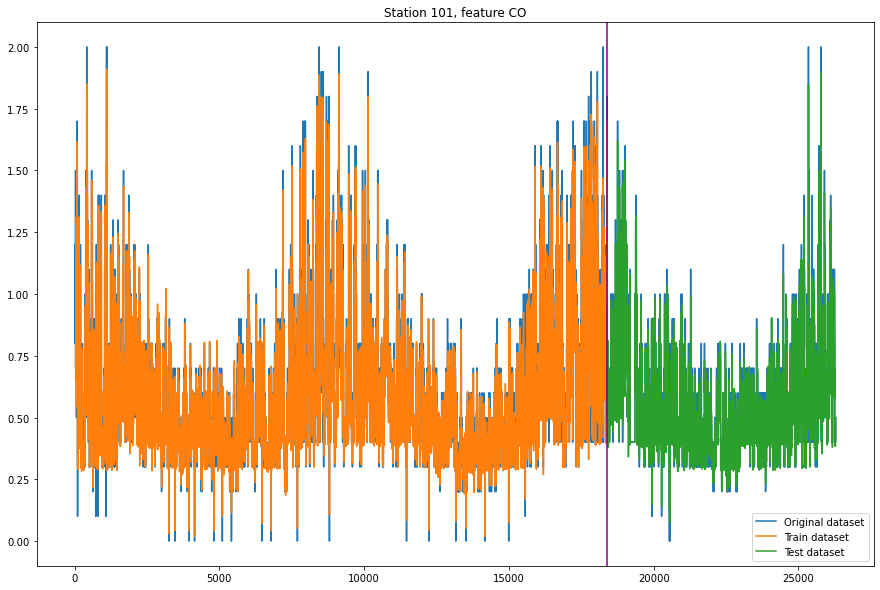

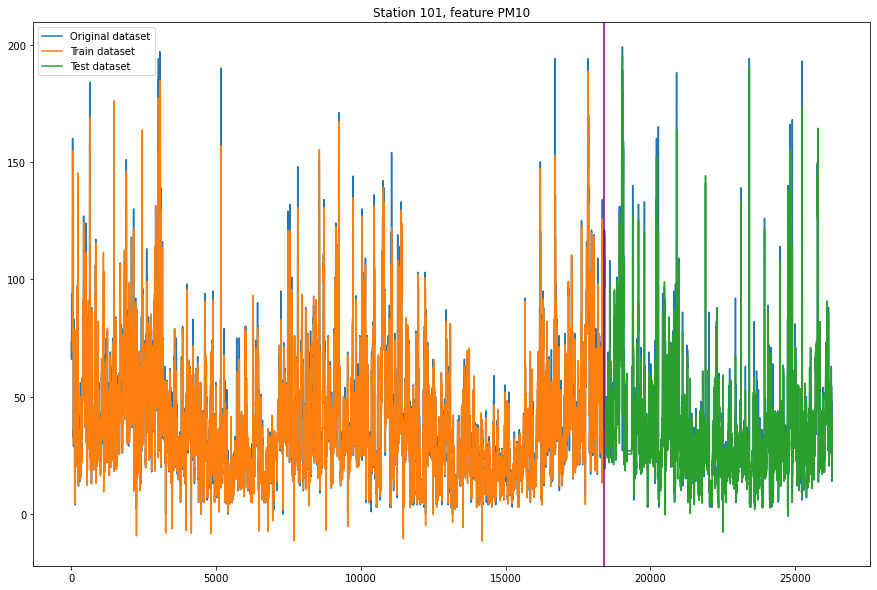

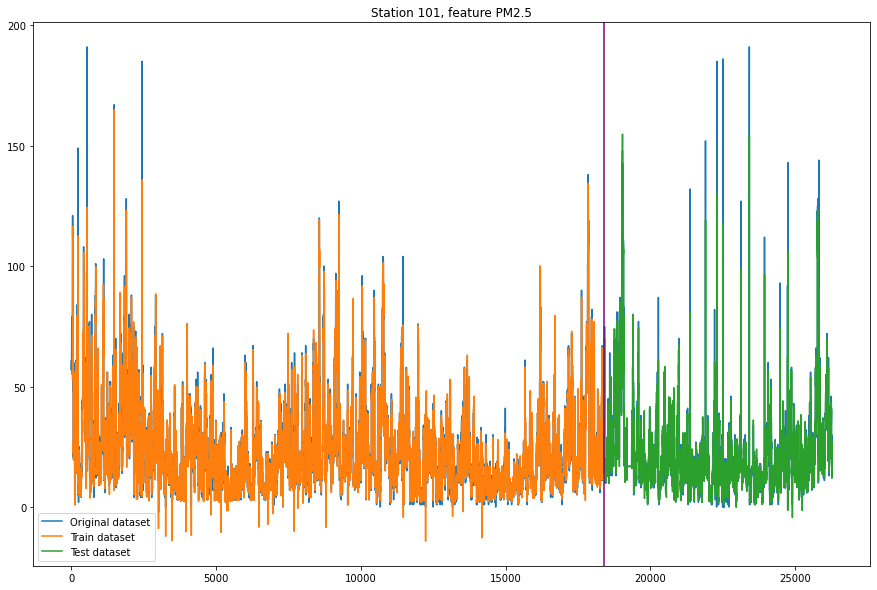

In [16]:
for indi, feature in enumerate(features):

    trainPredictPlot = np.empty_like(df1)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[time_step:len(train_predict)+time_step, :] = scaler.inverse_transform(train_predict)
    
   
    testPredictPlot = np.empty_like(df1)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(time_step*2)+1-time_step:len(df1)-1, :] = scaler.inverse_transform(test_predict)
    
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(10)
    
    plt.plot(scaler.inverse_transform(df1)[:, indi], label = 'Original dataset')    
    plt.plot(trainPredictPlot[:, indi], label = 'Train dataset')
    plt.plot(testPredictPlot[:, indi], label = 'Test dataset')
    
    plt.axvline(x = len(train_predict) + time_step, color = 'purple')
    plt.title(f"Station 101, feature {feature}")
    plt.legend()
    plt.show()

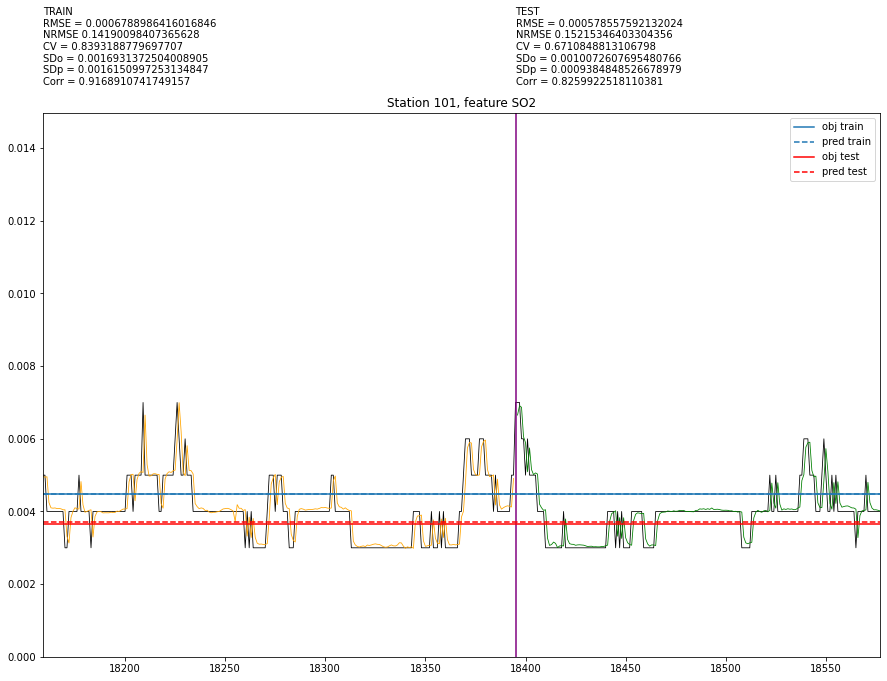

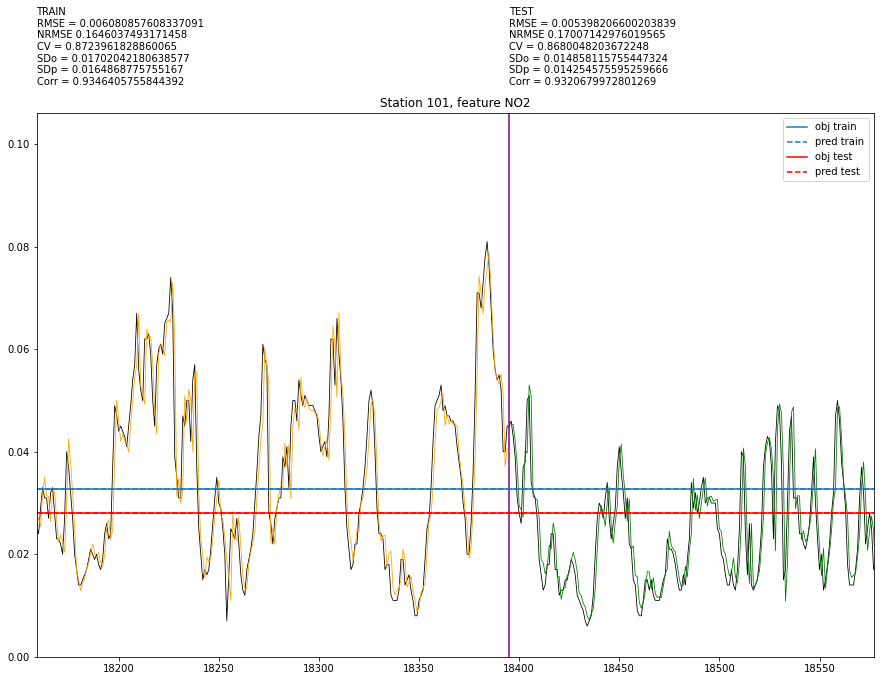

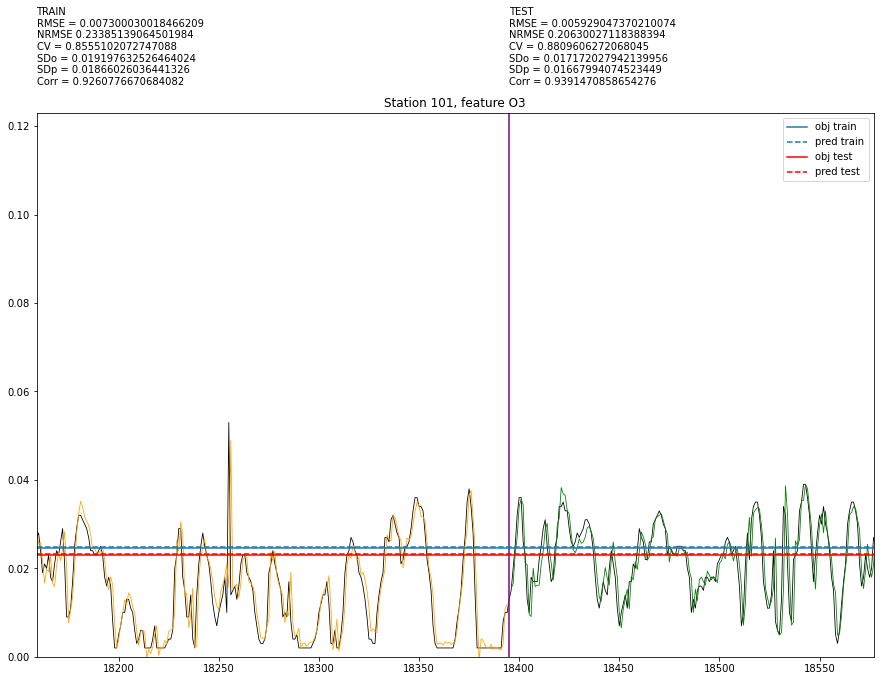

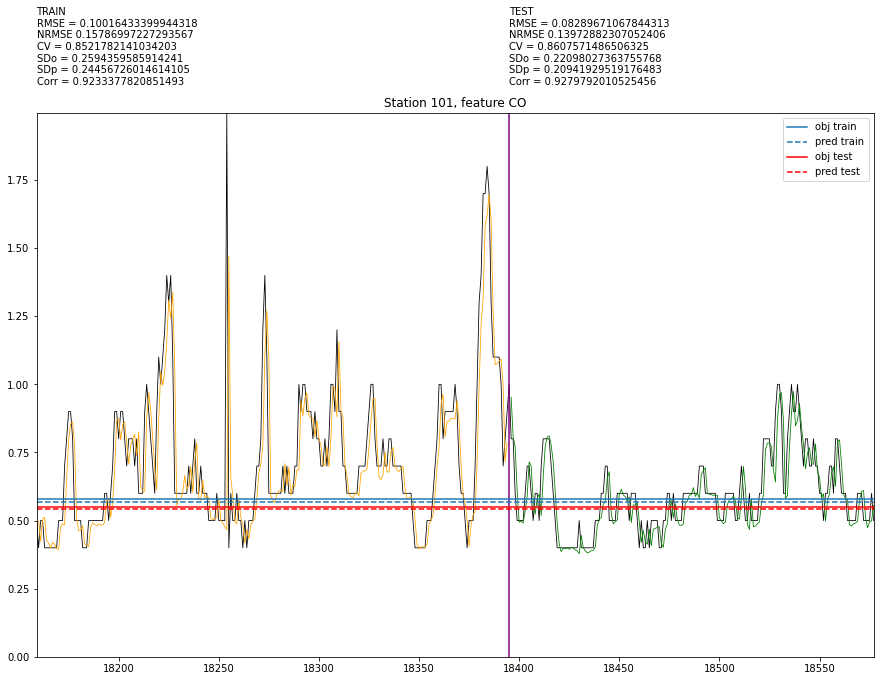

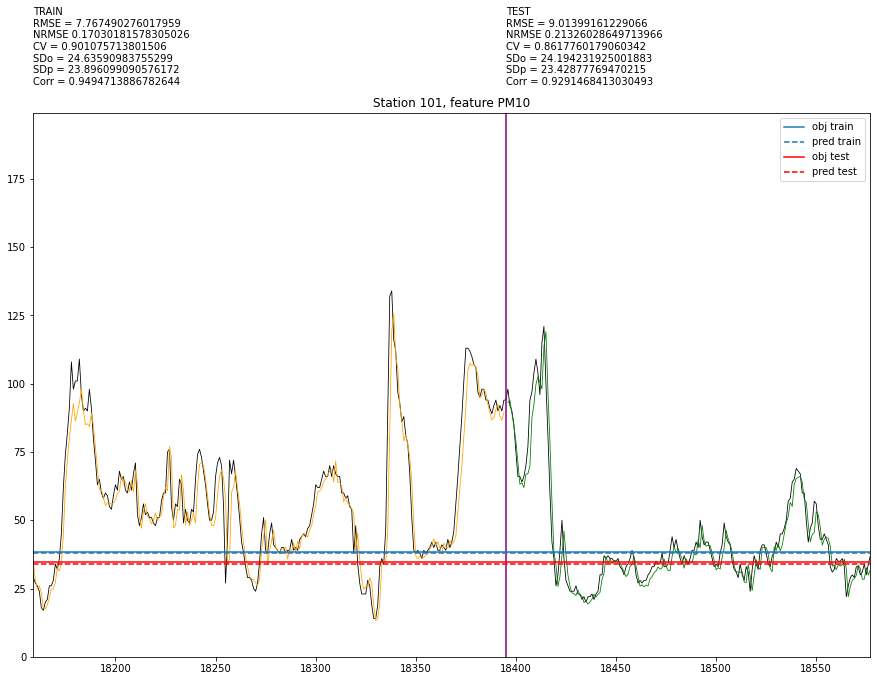

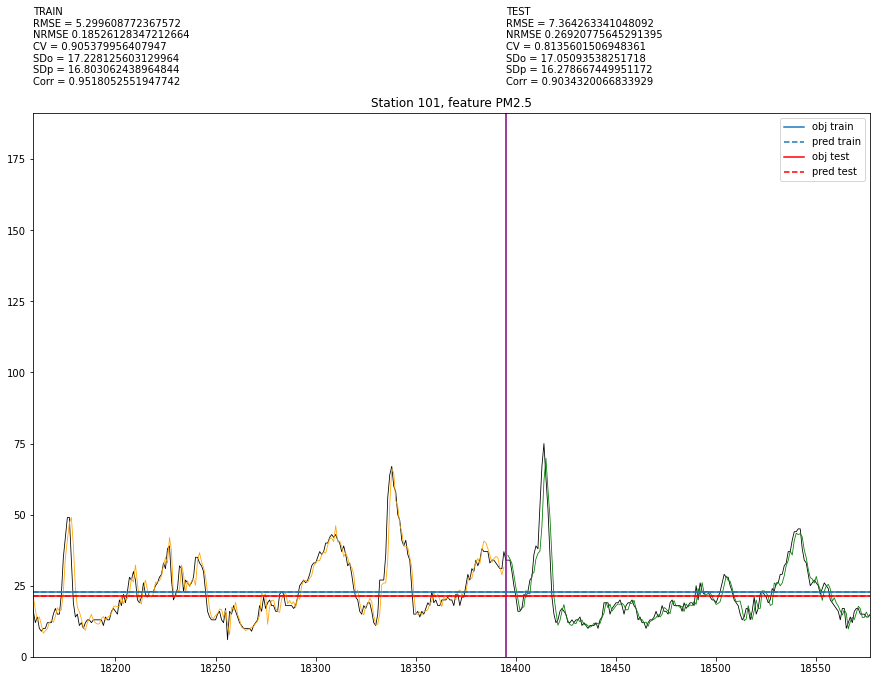

In [17]:
shift = 200
for indi, feature in enumerate(features):
 
    trainPredictPlot = np.empty_like(df1)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[time_step:len(train_predict)+time_step, :] = scaler.inverse_transform(train_predict)
    
    testPredictPlot = np.empty_like(df1)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(time_step*2)+1-time_step:len(df1)-1, :] = scaler.inverse_transform(test_predict)
    
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(10)

    plt.plot(scaler.inverse_transform(df1)[:, indi], color = 'black', linewidth = 0.8)
    plt.plot(trainPredictPlot[:, indi], color = 'orange', linewidth = 0.8)
    plt.plot(testPredictPlot[:, indi], color = 'green', linewidth = 0.8)

    xmin, xmax, ymin, ymax = plt.axis()
    plt.axis([len(train_predict) - shift, len(train_predict)+time_step/2 + shift, 0, ymax*0.95])

    plt.axvline(x=len(train_predict)+time_step, color = 'purple')
    plt.axhline(y = scaler.inverse_transform(y_train)[:,indi].mean(), label = 'obj train')
    plt.axhline(y = scaler.inverse_transform(train_predict)[:,indi].mean(), label = 'pred train', linestyle = 'dashed')
    plt.axhline(y = scaler.inverse_transform(y_test)[:,indi].mean(), label = 'obj test', color = 'red')
    plt.axhline(y = scaler.inverse_transform(test_predict)[:,indi].mean(), label = 'pred test', color = 'red', linestyle = 'dashed')
    

    obj = np.array([j[indi] for j in scaler.inverse_transform(y_train)])
    pred = np.array([j[indi] for j in scaler.inverse_transform(train_predict)])    
    plt.text(len(train_predict) - shift, ymax, 
    f"""TRAIN
RMSE = {mean_squared_error(obj, pred, squared=False)}
NRMSE {normalized_root_mse(obj, pred)}
CV = {explained_variance_score(obj, pred)}
SDo = {obj.std()}
SDp = {pred.std()}
Corr = {np.corrcoef(np.vstack((obj, pred)))[0][1]}""")


    obj = np.array([j[indi] for j in scaler.inverse_transform(y_test)])
    pred = np.array([j[indi] for j in scaler.inverse_transform(test_predict)])  
    plt.text(len(train_predict) + time_step, ymax, 
    f"""TEST
RMSE = {mean_squared_error(obj, pred, squared=False)}
NRMSE {normalized_root_mse(obj, pred)}
CV = {explained_variance_score(obj, pred)}
SDo = {obj.std()}
SDp = {pred.std()}
Corr = {np.corrcoef(np.vstack((obj, pred)))[0][1]}""")
                                                                 
    
    plt.title(f"Station 101, feature {feature}")
    plt.legend()
    plt.show()

In [18]:
from pprint import pprint
time_predict = 200
lst_output=[]

x_input = test_data[len(test_data) - time_step:]
temp_input = [x_input.tolist()]


for _ in range(time_predict):
    x_input = np.array(temp_input)
    #print(x_input)
    yhat = model.predict(x_input, verbose=0)
    #print(yhat)
    temp_input[0].extend(yhat.tolist())
    #print(temp_input)
    temp_input = [temp_input[0][1:]]
    #print('##########################')
    #pprint(temp_input)
    lst_output.extend(yhat.tolist())
    #break


Предикт для 200 часов или 8 дней и 8 часов


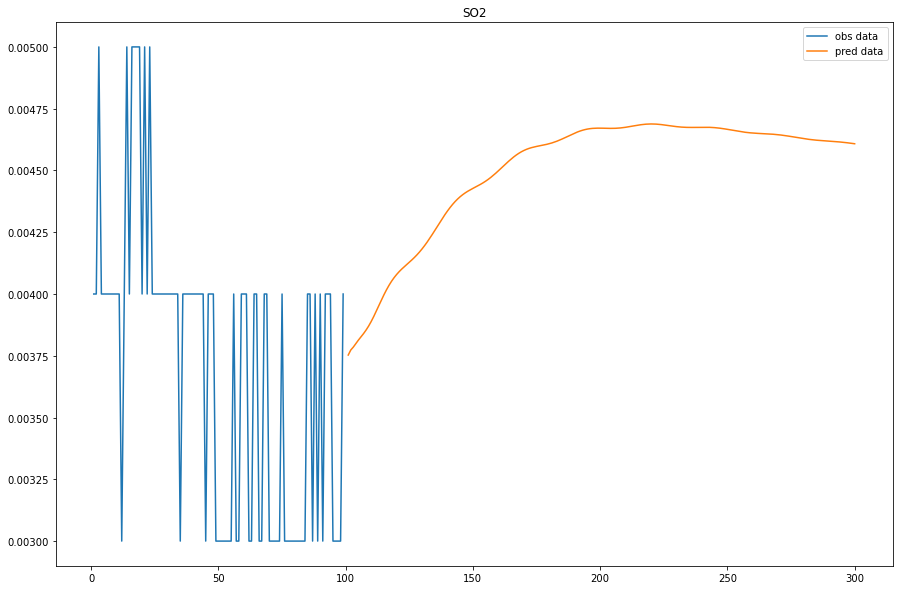

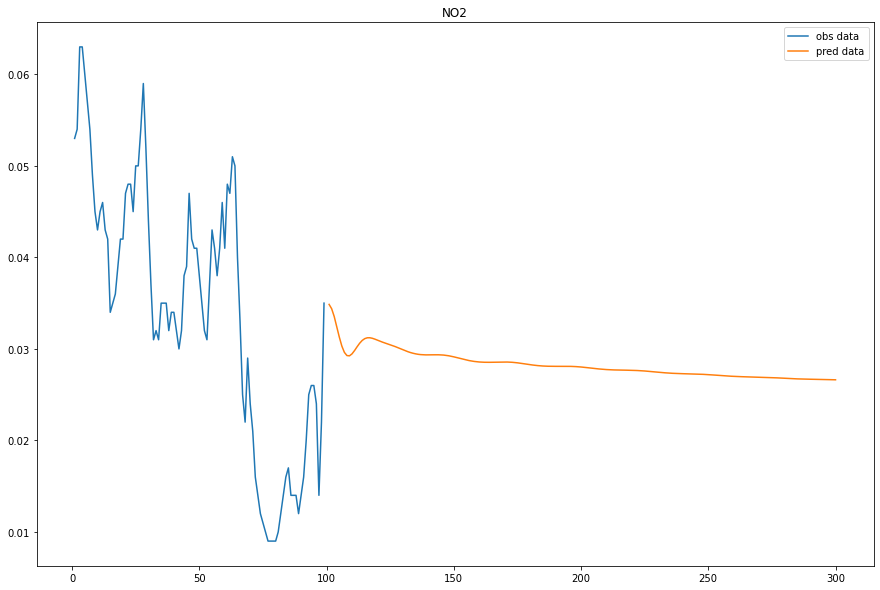

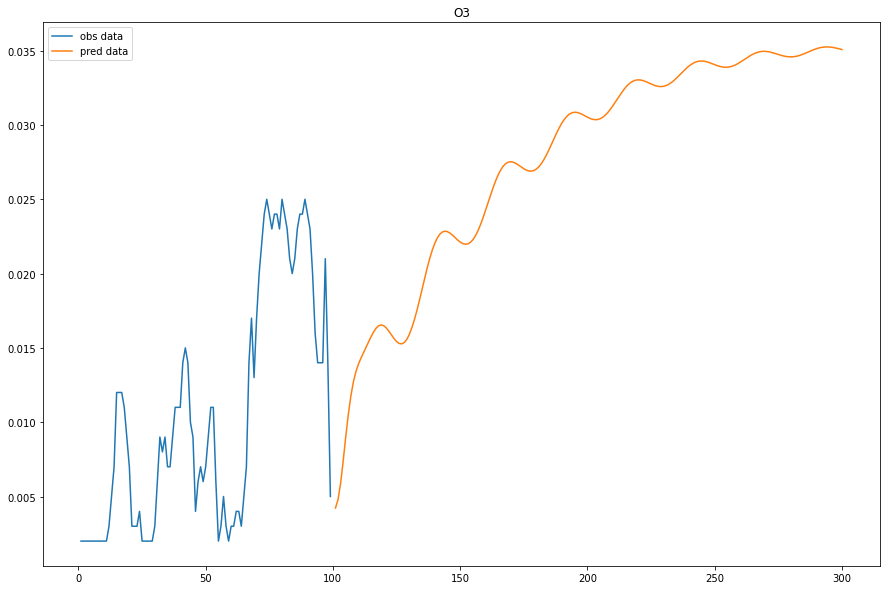

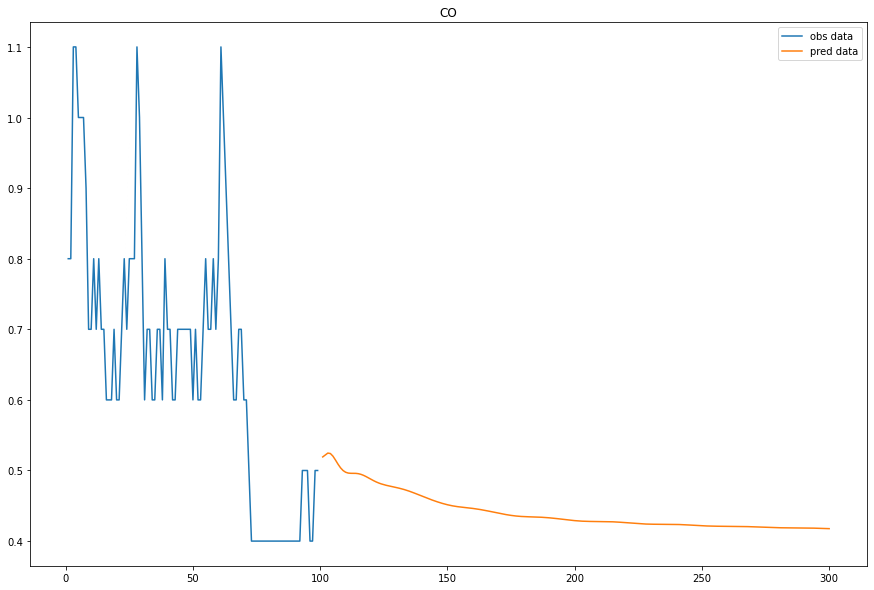

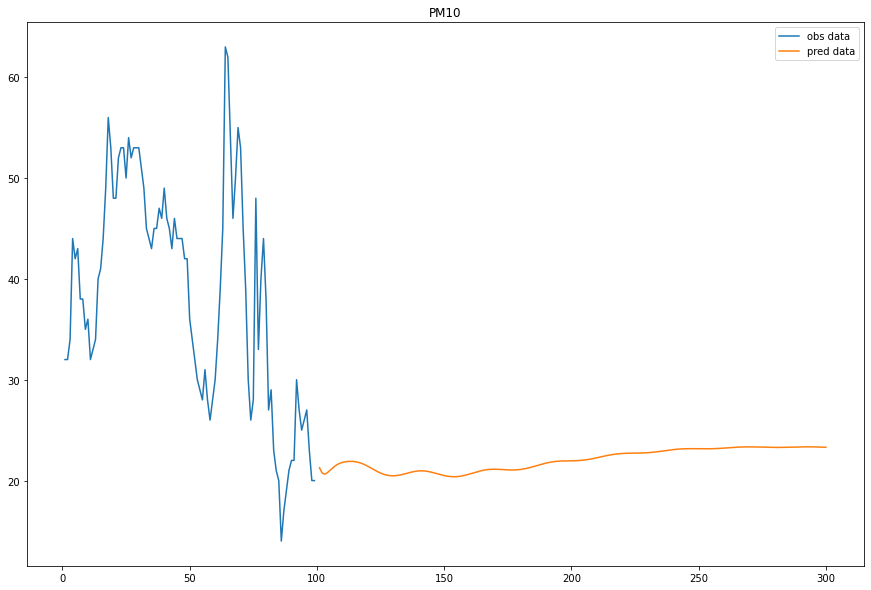

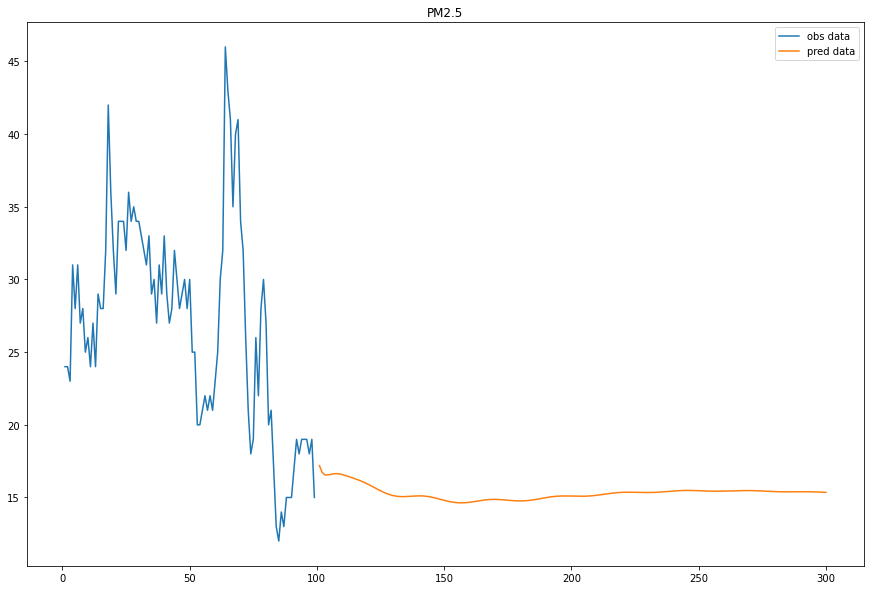

In [19]:
day_new=np.arange(1, 100)
day_pred=np.arange(101, 101 + time_predict)
print(f"Предикт для {time_predict} часов или {int(time_predict/24)} дней и {time_predict - 24*int(time_predict/24)} часов")
for indi, feature in enumerate(features):
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(10)
    plt.plot(day_new, scaler.inverse_transform(df1)[len(df1) - 99:,indi], label = 'obs data')
    plt.plot(day_pred, [i[indi] for i in scaler.inverse_transform(lst_output)], label = 'pred data')
    plt.title(feature)
    plt.legend()
    plt.show()

In [20]:
learning_rate = 0.001
model = Sequential()
model.add(GRU(128, input_shape = (X_test.shape[1:])))
#model.add(LSTM(128, return_sequences = True))
#model.add(LSTM(128))
#model.add(Activation('softmax'))
model.add(Dense(X_test.shape[2]))
model.compile(optimizer = keras.optimizers.Adam(learning_rate = learning_rate), loss = "mean_absolute_error", metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               52224     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 52,998
Trainable params: 52,998
Non-trainable params: 0
_________________________________________________________________


In [21]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0, patience = 5, restore_best_weights=True)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor = "val_loss",
    filepath = path_checkpoint,
    verbose = 1,
    save_weights_only = True,
    save_best_only = True,
)

history = model.fit(
    X_train,
    y_train,
    validation_data = (X_test, y_test),
    epochs = 100,
    batch_size = 256,
    verbose = 1,
    #callbacks = [es_callback, modelckpt_callback]
    callbacks = [es_callback]
    )

Epoch 1/100
72/72 [==============================] - 6s 47ms/step - loss: 0.0724 - accuracy: 0.4657 - val_loss: 0.0404 - val_accuracy: 0.6420
Epoch 2/100
72/72 [==============================] - 2s 34ms/step - loss: 0.0388 - accuracy: 0.7151 - val_loss: 0.0310 - val_accuracy: 0.7216
Epoch 3/100
72/72 [==============================] - 2s 24ms/step - loss: 0.0328 - accuracy: 0.7523 - val_loss: 0.0287 - val_accuracy: 0.7512
Epoch 4/100
72/72 [==============================] - 2s 24ms/step - loss: 0.0309 - accuracy: 0.7661 - val_loss: 0.0272 - val_accuracy: 0.7604
Epoch 5/100
72/72 [==============================] - 3s 38ms/step - loss: 0.0301 - accuracy: 0.7718 - val_loss: 0.0270 - val_accuracy: 0.7633
Epoch 6/100
72/72 [==============================] - 3s 35ms/step - loss: 0.0296 - accuracy: 0.7765 - val_loss: 0.0265 - val_accuracy: 0.7585
Epoch 7/100
72/72 [==============================] - 2s 34ms/step - loss: 0.0292 - accuracy: 0.7767 - val_loss: 0.0260 - val_accuracy: 0.7621
Epoch 

In [22]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
features = df.columns.values
features

array(['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5'], dtype=object)

In [23]:
print('Train values')
for i, feature in enumerate(features):
    obj = [j[i] for j in scaler.inverse_transform(y_train)]
    pred = [j[i] for j in scaler.inverse_transform(train_predict)]
    print(f'RMSE for {feature} is {mean_squared_error(obj, pred, squared=False)}')
    print(f'CV for {feature} is {explained_variance_score(obj, pred)}')
    print(f'NRMSE {normalized_root_mse(np.array(obj), np.array(pred))}')
    print()

Train values
RMSE for SO2 is 0.000702531393190754
CV for SO2 is 0.8278460111117001
NRMSE 0.1468406179178859

RMSE for NO2 is 0.006149855281561699
CV for NO2 is 0.8695349096751472
NRMSE 0.16647145884735393

RMSE for O3 is 0.00770001814574212
CV for O3 is 0.8392948858856392
NRMSE 0.24666473244886927

RMSE for CO is 0.10293575217460911
CV for CO is 0.8425788694104996
NRMSE 0.16223803117175079

RMSE for PM10 is 7.792288633293142
CV for PM10 is 0.8999756002519277
NRMSE 0.17084551846207896

RMSE for PM2.5 is 5.311625739044512
CV for PM2.5 is 0.9052184527020688
NRMSE 0.1856813670604888



In [24]:
print('Test values')
for i, feature in enumerate(features):
    obj = [j[i] for j in scaler.inverse_transform(y_test)]
    pred = [j[i] for j in scaler.inverse_transform(test_predict)]
    print(f'RMSE for {feature} is {mean_squared_error(obj, pred, squared=False)}')
    print(f'CV for {feature} is {explained_variance_score(obj, pred)}')
    print()

Test values
RMSE for SO2 is 0.0006082593375169117
CV for SO2 is 0.6353355064652055

RMSE for NO2 is 0.005437027843567454
CV for NO2 is 0.8660962904604118

RMSE for O3 is 0.006130792965189097
CV for O3 is 0.8726079617484136

RMSE for CO is 0.0848917234430467
CV for CO is 0.8524843505492005

RMSE for PM10 is 9.078997610217868
CV for PM10 is 0.8592119304781448

RMSE for PM2.5 is 7.587205870685599
CV for PM2.5 is 0.8026579178784938



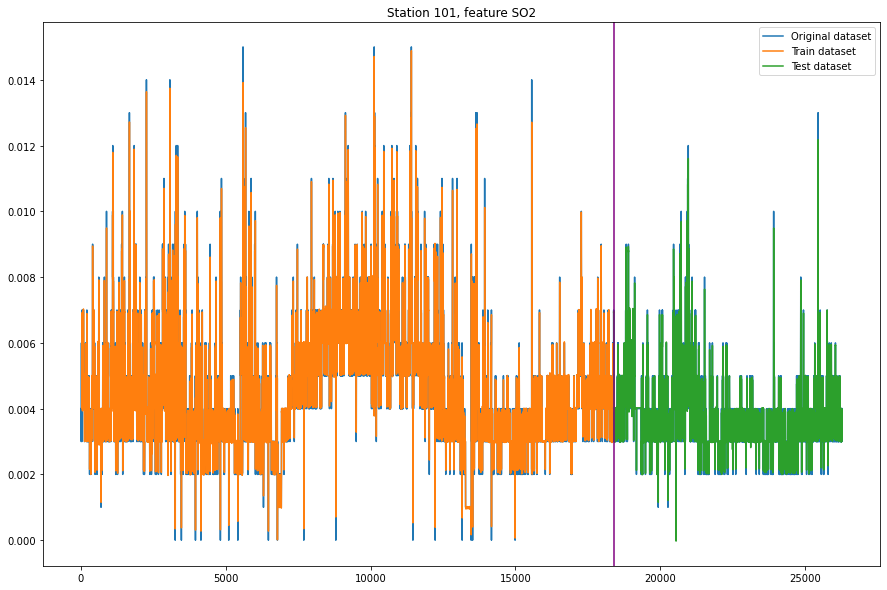

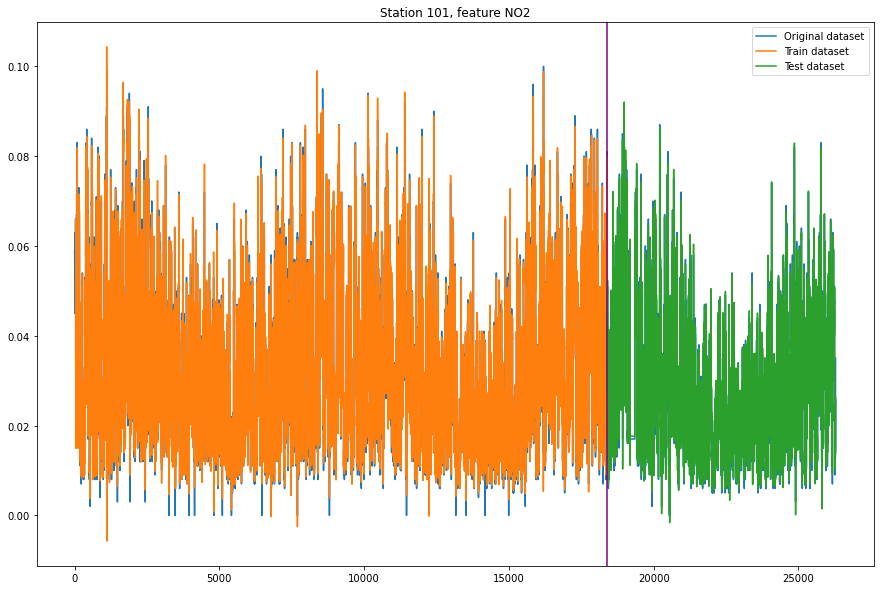

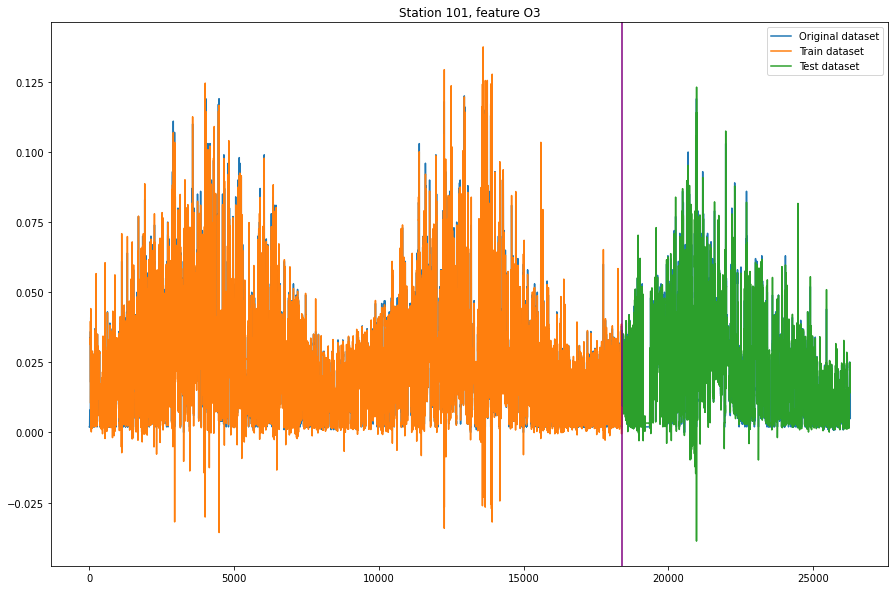

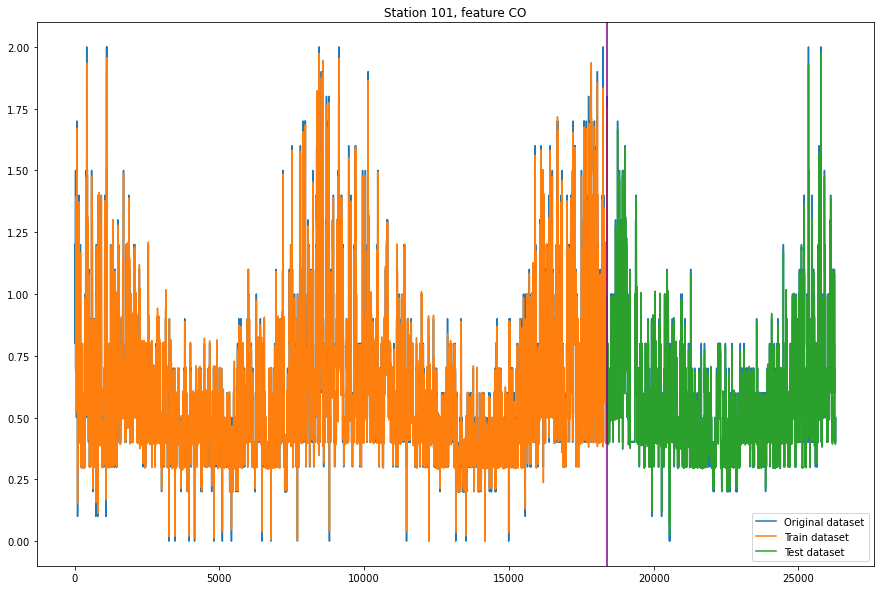

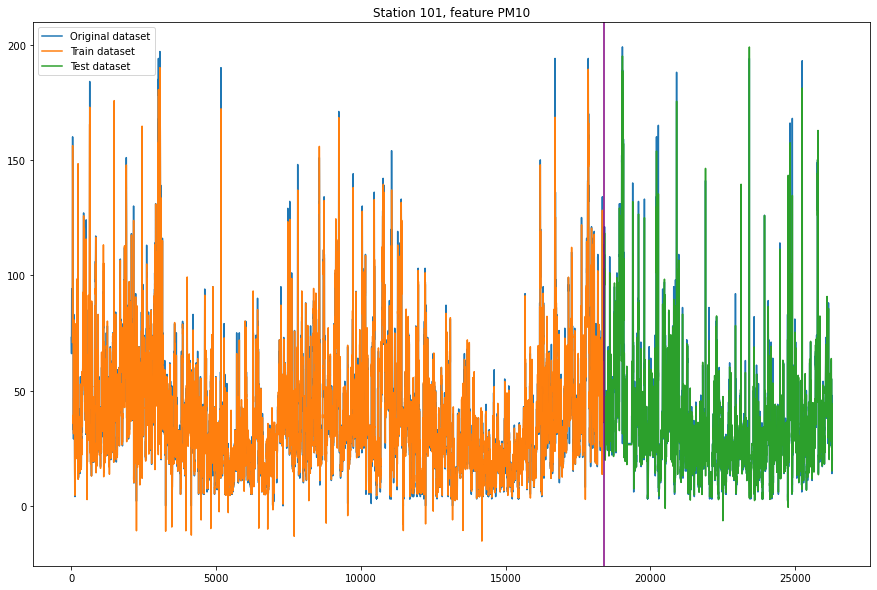

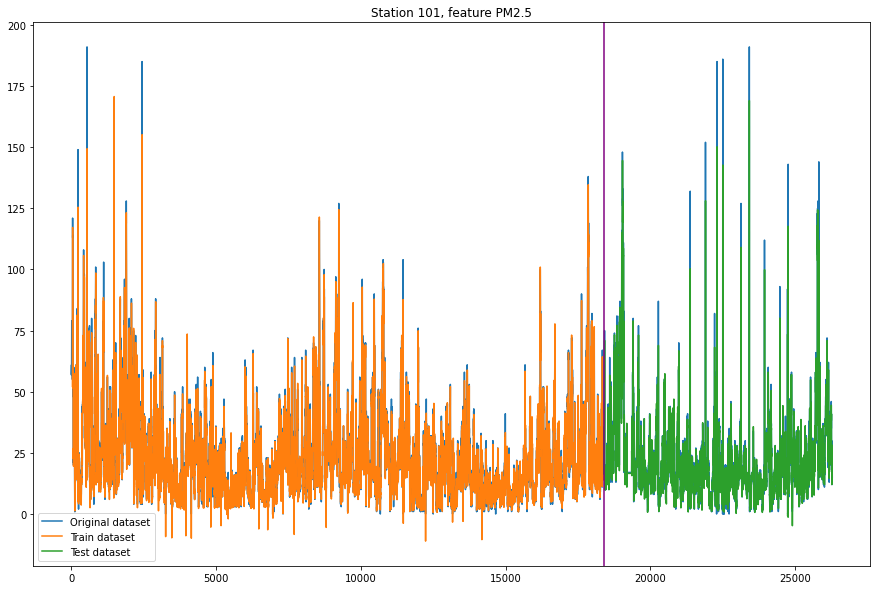

In [25]:
for indi, feature in enumerate(features):

    trainPredictPlot = np.empty_like(df1)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[time_step:len(train_predict)+time_step, :] = scaler.inverse_transform(train_predict)
    
   
    testPredictPlot = np.empty_like(df1)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(time_step*2)+1-time_step:len(df1)-1, :] = scaler.inverse_transform(test_predict)
    
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(10)
    
    plt.plot(scaler.inverse_transform(df1)[:, indi], label = 'Original dataset')    
    plt.plot(trainPredictPlot[:, indi], label = 'Train dataset')
    plt.plot(testPredictPlot[:, indi], label = 'Test dataset')
    
    plt.axvline(x = len(train_predict) + time_step, color = 'purple')
    plt.title(f"Station 101, feature {feature}")
    plt.legend()
    plt.show()

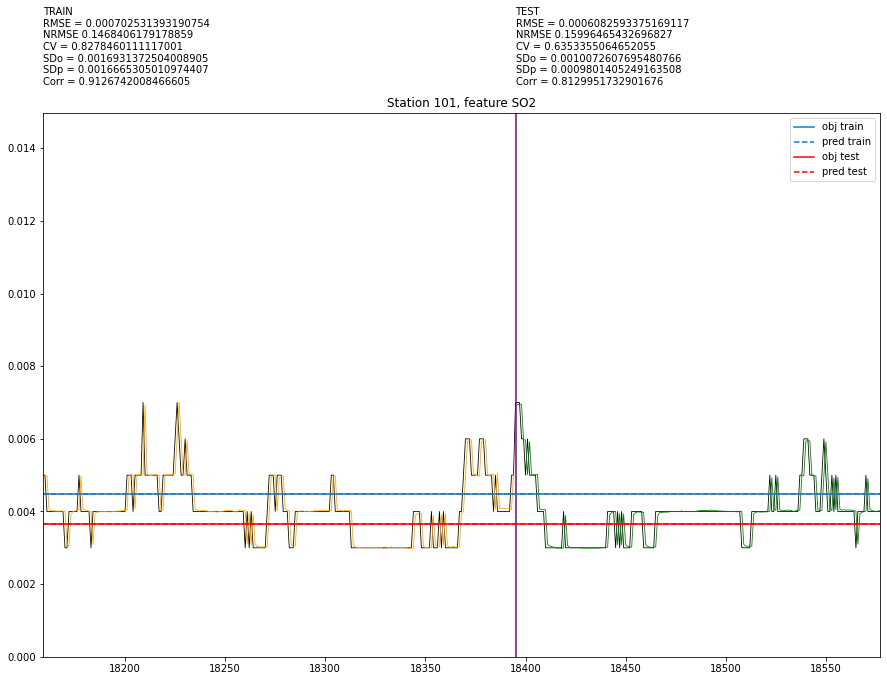

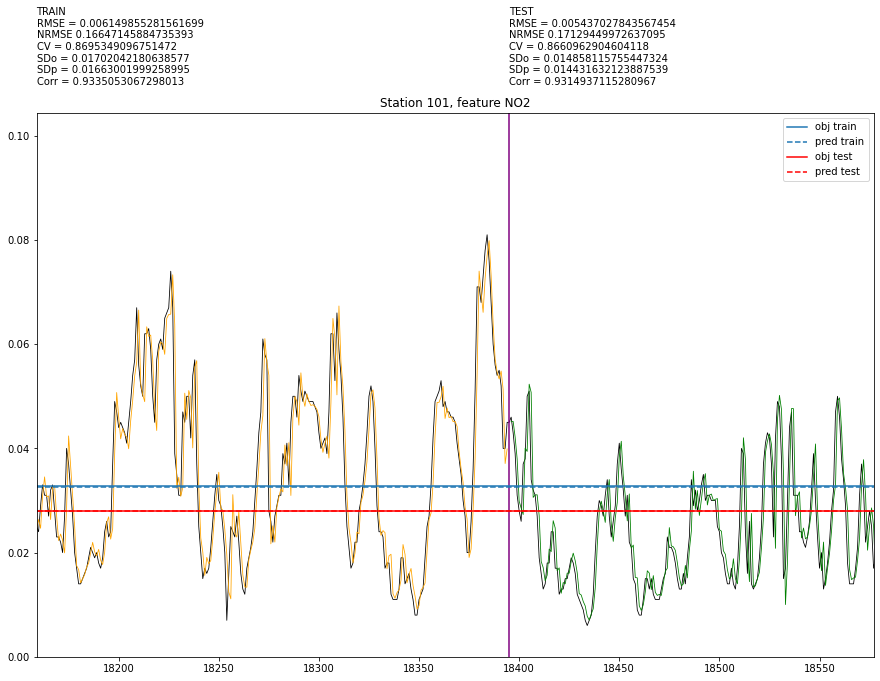

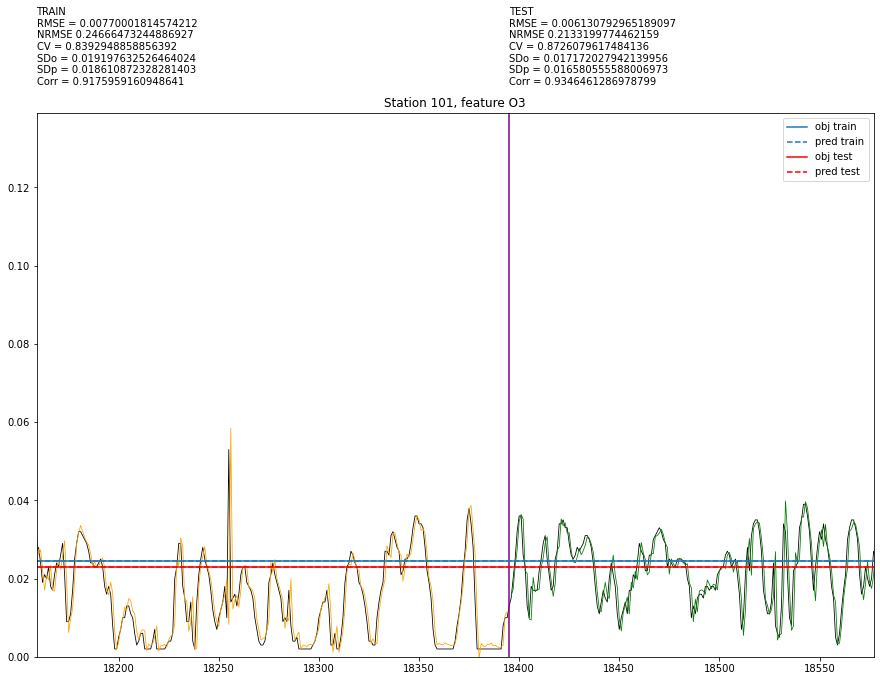

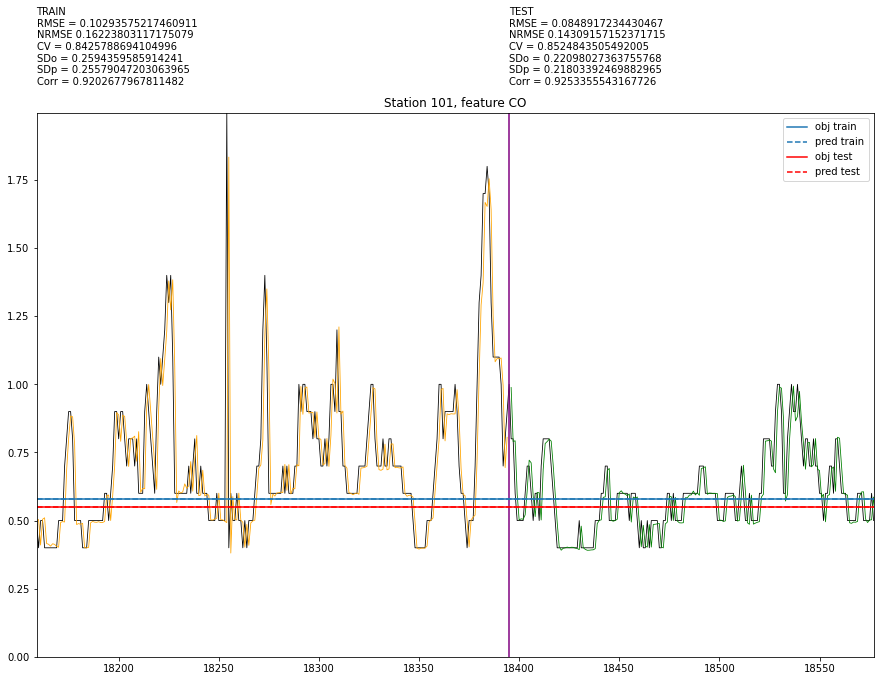

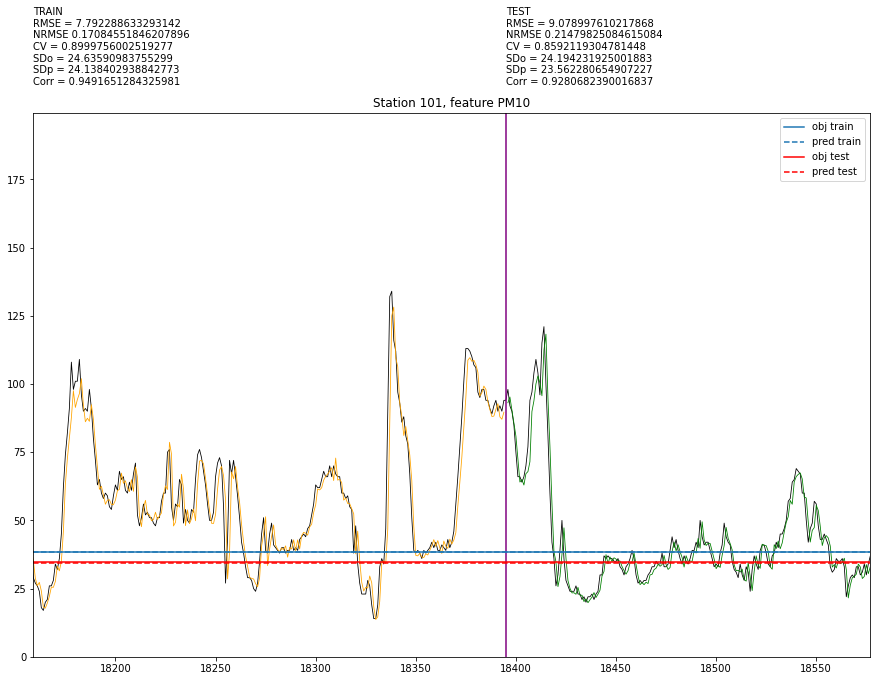

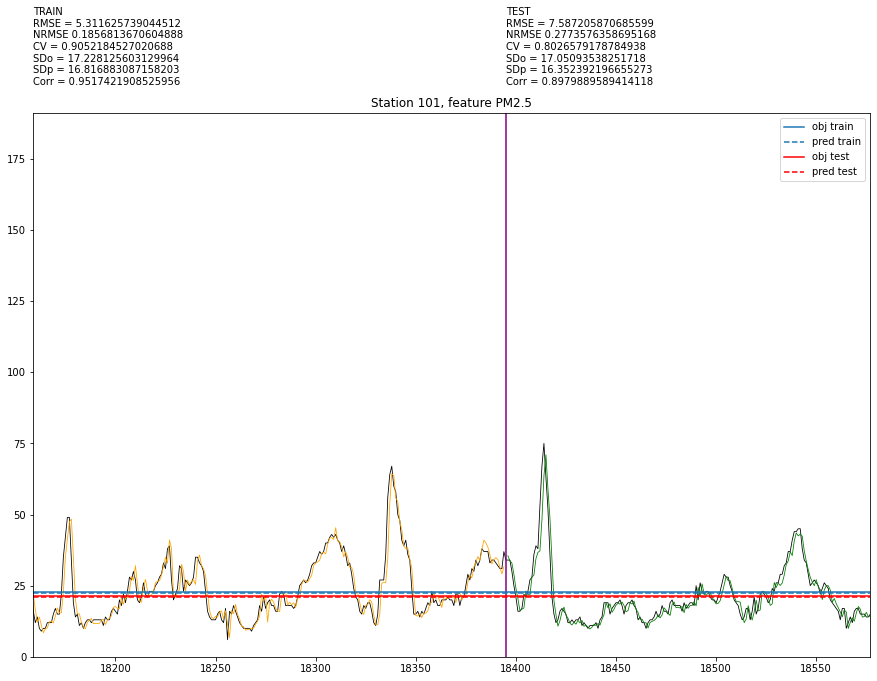

In [26]:
shift = 200
for indi, feature in enumerate(features):
 
    trainPredictPlot = np.empty_like(df1)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[time_step:len(train_predict)+time_step, :] = scaler.inverse_transform(train_predict)
    
    testPredictPlot = np.empty_like(df1)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(time_step*2)+1-time_step:len(df1)-1, :] = scaler.inverse_transform(test_predict)
    
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(10)

    plt.plot(scaler.inverse_transform(df1)[:, indi], color = 'black', linewidth = 0.8)
    plt.plot(trainPredictPlot[:, indi], color = 'orange', linewidth = 0.8)
    plt.plot(testPredictPlot[:, indi], color = 'green', linewidth = 0.8)

    xmin, xmax, ymin, ymax = plt.axis()
    plt.axis([len(train_predict) - shift, len(train_predict)+time_step/2 + shift, 0, ymax*0.95])

    plt.axvline(x=len(train_predict)+time_step, color = 'purple')
    plt.axhline(y = scaler.inverse_transform(y_train)[:,indi].mean(), label = 'obj train')
    plt.axhline(y = scaler.inverse_transform(train_predict)[:,indi].mean(), label = 'pred train', linestyle = 'dashed')
    plt.axhline(y = scaler.inverse_transform(y_test)[:,indi].mean(), label = 'obj test', color = 'red')
    plt.axhline(y = scaler.inverse_transform(test_predict)[:,indi].mean(), label = 'pred test', color = 'red', linestyle = 'dashed')
    

    obj = np.array([j[indi] for j in scaler.inverse_transform(y_train)])
    pred = np.array([j[indi] for j in scaler.inverse_transform(train_predict)])    
    plt.text(len(train_predict) - shift, ymax, 
    f"""TRAIN
RMSE = {mean_squared_error(obj, pred, squared=False)}
NRMSE {normalized_root_mse(obj, pred)}
CV = {explained_variance_score(obj, pred)}
SDo = {obj.std()}
SDp = {pred.std()}
Corr = {np.corrcoef(np.vstack((obj, pred)))[0][1]}""")


    obj = np.array([j[indi] for j in scaler.inverse_transform(y_test)])
    pred = np.array([j[indi] for j in scaler.inverse_transform(test_predict)])  
    plt.text(len(train_predict) + time_step, ymax, 
    f"""TEST
RMSE = {mean_squared_error(obj, pred, squared=False)}
NRMSE {normalized_root_mse(obj, pred)}
CV = {explained_variance_score(obj, pred)}
SDo = {obj.std()}
SDp = {pred.std()}
Corr = {np.corrcoef(np.vstack((obj, pred)))[0][1]}""")
                                                                 
    
    plt.title(f"Station 101, feature {feature}")
    plt.legend()
    plt.show()

In [27]:
time_predict = 200
lst_output=[]

x_input = test_data[len(test_data) - time_step:]
temp_input = [x_input.tolist()]


for _ in range(time_predict):
    x_input = np.array(temp_input)
    #print(x_input)
    yhat = model.predict(x_input, verbose=0)
    #print(yhat)
    temp_input[0].extend(yhat.tolist())
    #print(temp_input)
    temp_input = [temp_input[0][1:]]
    #print('##########################')
    #pprint(temp_input)
    lst_output.extend(yhat.tolist())
    #break

Предикт для 200 часов или 8 дней и 8 часов


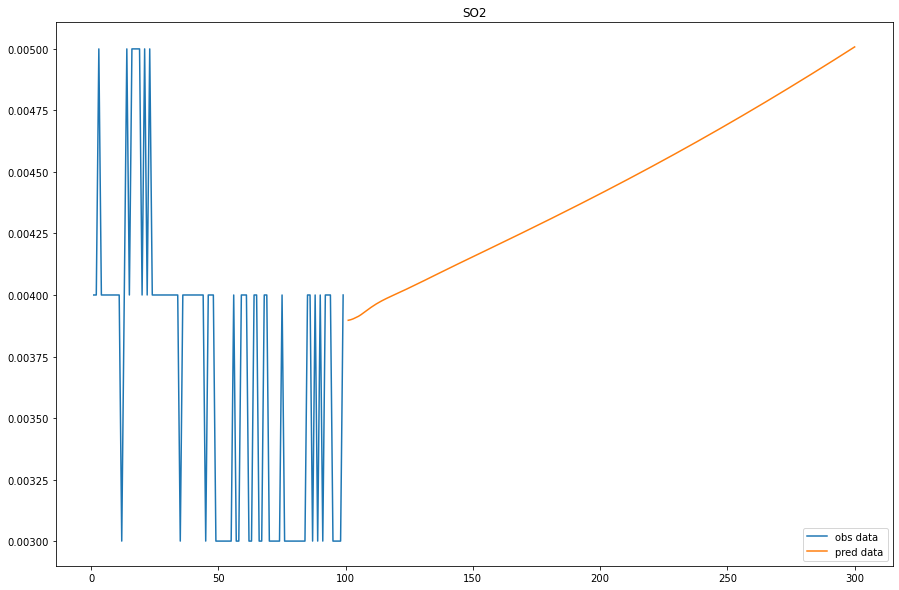

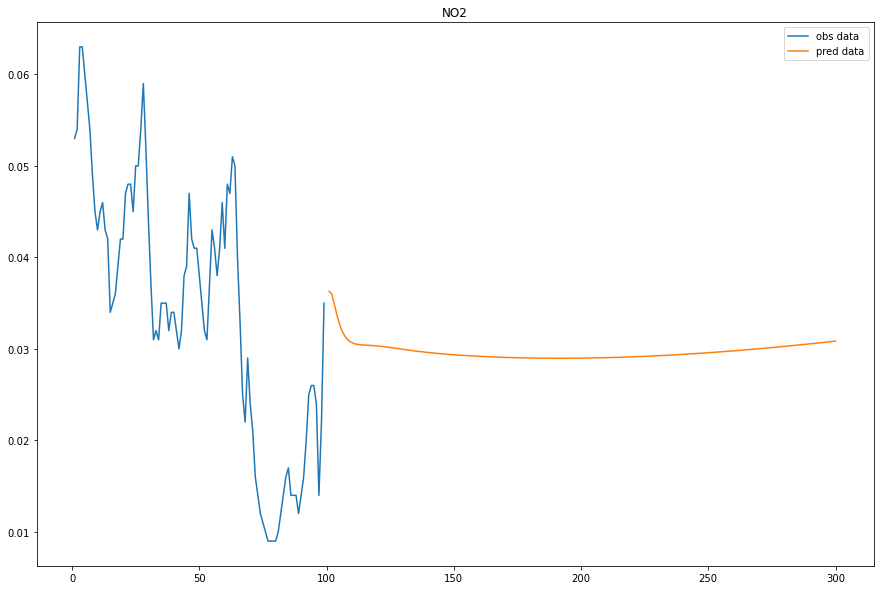

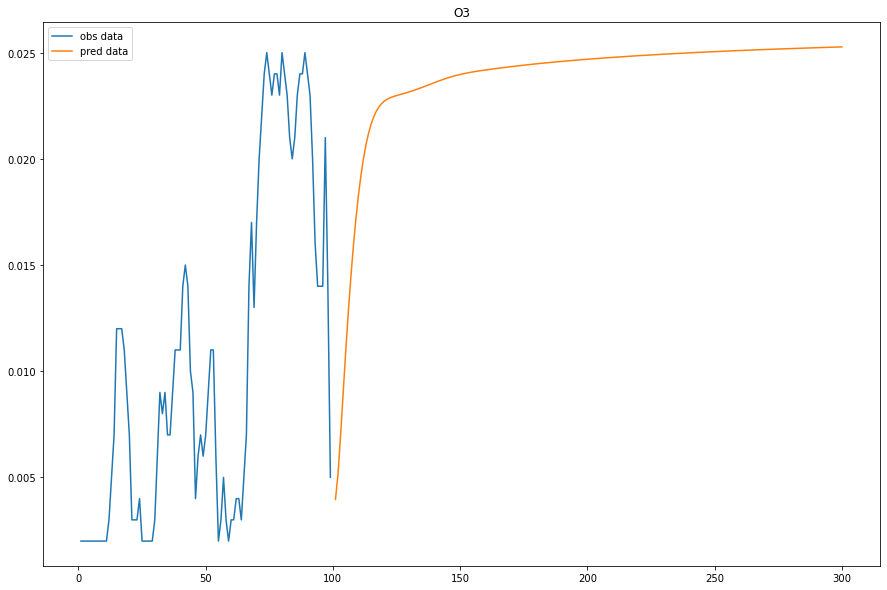

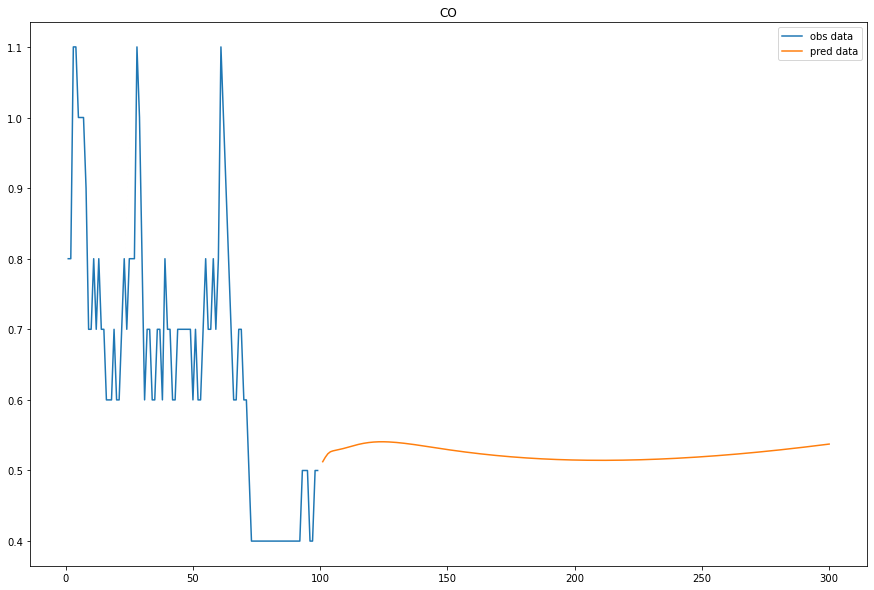

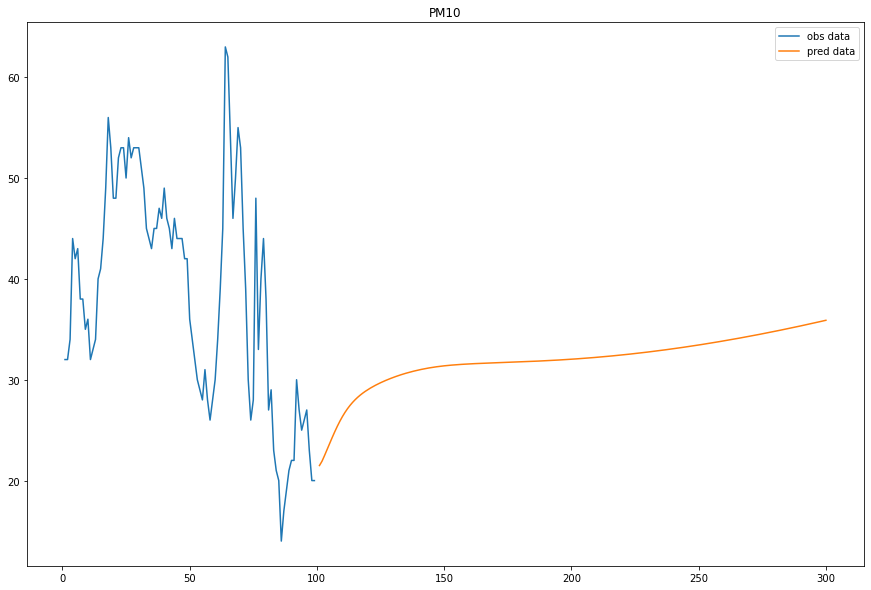

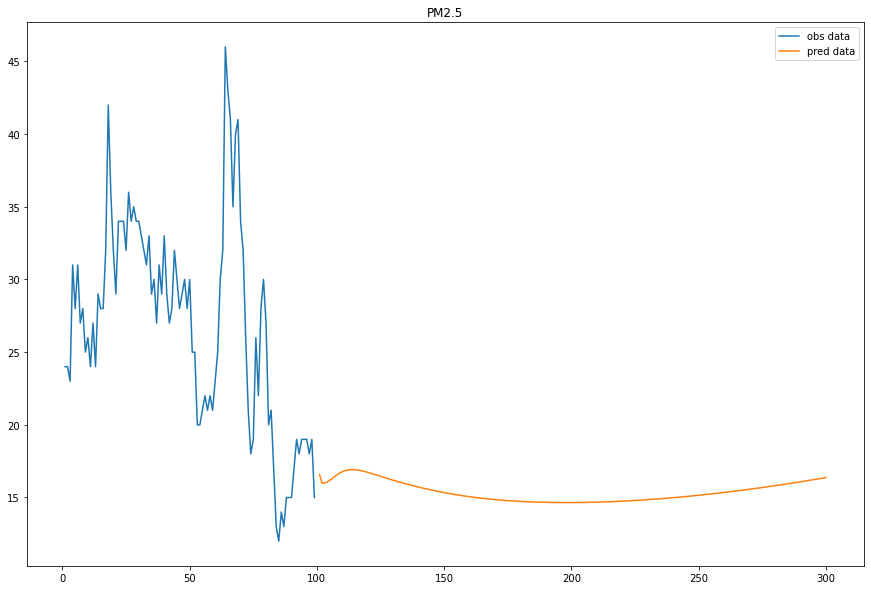

In [28]:
day_new=np.arange(1, 100)
day_pred=np.arange(101, 101 + time_predict)
print(f"Предикт для {time_predict} часов или {int(time_predict/24)} дней и {time_predict - 24*int(time_predict/24)} часов")
for indi, feature in enumerate(features):
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(10)
    plt.plot(day_new, scaler.inverse_transform(df1)[len(df1) - 99:,indi], label = 'obs data')
    plt.plot(day_pred, [i[indi] for i in scaler.inverse_transform(lst_output)], label = 'pred data')
    plt.title(feature)
    plt.legend()
    plt.show()